In [1]:
%matplotlib inline

In [2]:
import pycomlink as pycml
import numpy as np

In [3]:
cml_list = pycml.io.examples.get_75_cmls()

100%|██████████| 75/75 [00:01<00:00, 71.91it/s]


In [4]:
# convert time (TODO: add this to cmlh5 parsing function)
for cml in cml_list:
    # Time is stored in seconds since epoch in cmlh5 and should be represented 
    # by np.datetime64 in nanoseconds
    cml['time'] = (cml.time.values * 1e9).astype("datetime64[ns]")

In [5]:
cml = cml_list[0]

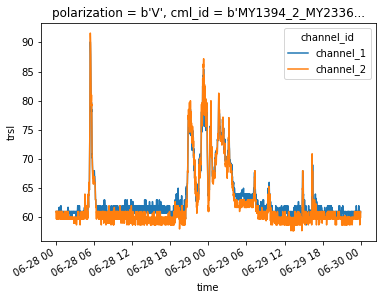

In [6]:
cml['trsl'] = cml.tsl - cml.rsl
cml.trsl.plot.line(x='time');

In [7]:
cml['wet'] = cml.trsl.rolling(time=60, center=True).std() > 0.8

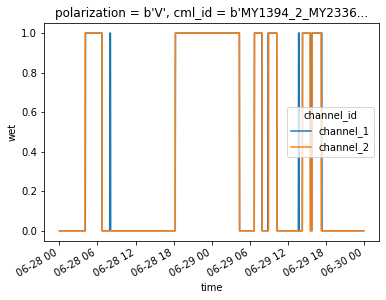

In [8]:
cml.wet.astype('float').plot.line(x='time');

In [9]:
# TODO: Allow to pass 2D arrays or even xarray Dataarrays
cml['baseline'] = ('channel_id', 'time'), np.stack([
    pycml.processing.baseline.baseline_constant(cml.isel(channel_id=0).trsl.values, cml.isel(channel_id=0).wet.values),
    pycml.processing.baseline.baseline_constant(cml.isel(channel_id=1).trsl.values, cml.isel(channel_id=1).wet.values)
])

# WIP decorator to apply processing along time dimesio of individual channels 

TODO: 
* Handle xr.Dataarrays as args, not only as kwargs
* Replace the whole mess with xr.apply_ufunc (if possible...)

In [11]:
from numba import jit
import pandas as pd
import xarray as xr

from functools import wraps
def xarray_loop_vars_over_dim(vars_to_loop, loop_dim):
    def decorator(func):
        @wraps(func)
        def inner(*args, **kwargs):
            if len(args) > 0 and isinstance(args[0], np.ndarray):
                return func(*args, **kwargs)
            if len(kwargs.keys()) > 0 and isinstance(kwargs[vars_to_loop[0]], np.ndarray):
                return func(*args, **kwargs)
            loop_dim_id_list = list(np.atleast_1d(kwargs[vars_to_loop[0]][loop_dim].values))
            if len(loop_dim_id_list) > 1:
                kwargs_vars_to_loop = {var: kwargs.pop(var) for var in vars_to_loop}
                data_list = []
                for loop_dim_id in loop_dim_id_list:
                    for var in vars_to_loop:
                        kwargs[var] = kwargs_vars_to_loop[var].sel({loop_dim: loop_dim_id})
                    data_list.append(func(**kwargs))   
                return xr.DataArray(
                    data=np.stack(data_list),
                    dims=(loop_dim, 'time'),
                    coords={
                        loop_dim: kwargs_vars_to_loop[vars_to_loop[0]][loop_dim].values,
                        'time': kwargs_vars_to_loop[vars_to_loop[0]].time
                    },
                )
            else:
                return xr.DataArray(
                    data=func(**kwargs),
                    dims=('time'),
                    coords={
                        'time': kwargs[vars_to_loop[0]].time
                    }
                )
        return inner
    return decorator

@xarray_loop_vars_over_dim(vars_to_loop=['rsl', 'wet'], loop_dim='channel_id')
def baseline_constant(rsl, wet):
    """ Some docstring """
    return _numba_baseline_constant(
        np.asarray(rsl, dtype=np.float64),
        np.asarray(wet, dtype=np.float64),
    )
                
@jit(nopython=True)
def _numba_baseline_constant(rsl, wet):
    baseline = np.zeros_like(rsl, dtype=np.float64)
    baseline[0] = rsl[0]
    for i in range(1, len(rsl)):
        if np.isnan(wet[i]):
            baseline[i] = np.NaN
        elif wet[i]:
            baseline[i] = baseline[i - 1]
        else:
            baseline[i] = rsl[i]
    return baseline


# Works now with xr.DataArrays as kwargs
baseline_constant(rsl=cml.trsl, wet=cml.wet)

<xarray.DataArray (channel_id: 2, time: 2750)>
array([[61. , 61. , 61. , ..., 60.7, 61. , 61. ],
       [61. , 61. , 61. , ..., 60. , 61. , 60. ]])
Coordinates:
  * channel_id  (channel_id) object 'channel_1' 'channel_2'
  * time        (time) datetime64[ns] 2017-06-28T00:00:10.241754112 ... 2017-06-29T23:59:10.229434880

In [12]:
# Works with 1D numpy arrays as kwargs
baseline_constant(rsl=cml.trsl.isel(channel_id=0).values, wet=cml.wet.isel(channel_id=0).values)

array([61. , 61. , 61. , ..., 60.7, 61. , 61. ])

In [13]:
# Works with 1D numpy arrays as args
baseline_constant(cml.trsl.isel(channel_id=0).values, cml.wet.isel(channel_id=0).values)

array([61. , 61. , 61. , ..., 60.7, 61. , 61. ])

In [14]:
# Does not work with xr.Dataarrays as args, because the inner function only looks in kwargs

In [15]:
baseline_constant(cml.trsl, cml.wet).plot.line(x='time')

@jit(nopython=True)
def _numba_waa_schleiss(rsl, baseline, waa_max, delta_t, tau, wet):
    waa = np.zeros_like(rsl, dtype=np.float64)
    A = rsl - baseline

    for i in range(1, len(rsl)):
        if wet[i] == True:
            waa[i] = min(
                A[i], waa_max, waa[i - 1] + (waa_max - waa[i - 1]) * 3 * delta_t / tau
            )
        else:
            waa[i] = min(A[i], waa_max)
    return waa

@xarray_loop_vars_over_dim(vars_to_loop=['rsl', 'baseline', 'wet'], loop_dim='channel_id')
def waa_adjust_baseline(rsl, baseline, wet, waa_max, delta_t, tau):
    waa = _numba_waa_schleiss(
        rsl=np.asarray(rsl, dtype=np.float64),
        baseline=np.asarray(baseline, dtype=np.float64),
        wet=np.asarray(wet, dtype=np.float64),
        waa_max=waa_max, 
        delta_t=delta_t, 
        tau=tau)

    # return baseline + waa, waa
    return baseline + waa

In [234]:
waa_adjust_baseline(rsl=cml.trsl, baseline=cml.baseline, wet=cml.wet, waa_max=2.3, delta_t=1, tau=15)

<xarray.DataArray (channel_id: 2, time: 2750)>
array([[61. , 61. , 61. , ..., 60.7, 61. , 61. ],
       [61. , 61. , 61. , ..., 60. , 61. , 60. ]])
Coordinates:
  * channel_id  (channel_id) object 'channel_1' 'channel_2'
  * time        (time) datetime64[ns] 2017-06-28T00:00:10.241754112 ... 2017-06-29T23:59:10.229434880

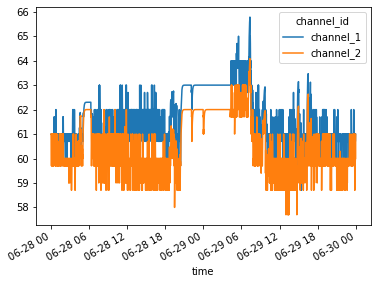

In [235]:
waa_adjust_baseline(rsl=cml.trsl, baseline=cml.baseline, wet=cml.wet, waa_max=2.3, delta_t=1, tau=15).plot.line(x='time')

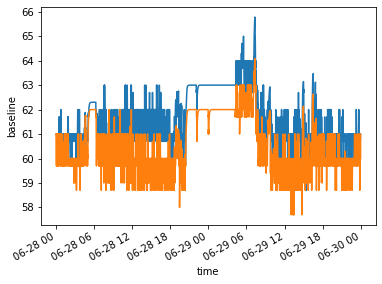

In [236]:
waa_adjust_baseline(
    rsl=cml.trsl.isel(channel_id=0), 
    baseline=cml.baseline.isel(channel_id=0), 
    wet=cml.wet.isel(channel_id=0), 
    waa_max=2.3, 
    delta_t=1, 
    tau=15).plot.line(x='time')

waa_adjust_baseline(
    rsl=cml.trsl.isel(channel_id=1), 
    baseline=cml.baseline.isel(channel_id=1), 
    wet=cml.wet.isel(channel_id=1), 
    waa_max=2.3, 
    delta_t=1, 
    tau=15).plot.line(x='time')

In [237]:
waa_adjust_baseline(
    rsl=cml.trsl.isel(channel_id=0).values, 
    baseline=cml.baseline.isel(channel_id=0).values, 
    wet=cml.wet.isel(channel_id=0).values, 
    waa_max=2.3, 
    delta_t=1, 
    tau=15)

array([61. , 61. , 61. , ..., 60.7, 61. , 61. ])

In [254]:
# non working try with `xr.apply_ufunc`

# def baseline_constant(rsl, wet):
#     """ Some docstring """
#     return _numba_baseline_constant(
#         np.asarray(rsl, dtype=np.float64),
#         np.asarray(wet, dtype=np.float64),
#     )


# xr.apply_ufunc(
#     baseline_constant,
#     cml.trsl,
#     cml.wet,
#     input_core_dims=[['channel_id', 'time'], ['channel_id', 'time']],
#     output_core_dims=[['channel_id', 'time']],
#     exclude_dims=set(('time', )),
# )

In [ ]:
# xr.apply_ufunc(
#     interp1d_np,  # first the function
#     air.isel(time=0, lon=0),  # now arguments in the order expected by 'interp1_np'
#     air.lat,
#     newlat,
#     input_core_dims=[["lat"], ["lat"], []],  # list with one entry per arg
#     output_core_dims=[["lat"]],
#     exclude_dims=set(("lat",)),  # dimensions allowed to change size. Must be set!
# )

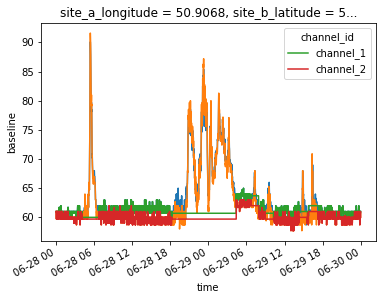

In [255]:
cml.trsl.plot.line(x='time')
cml.baseline.plot.line(x='time');

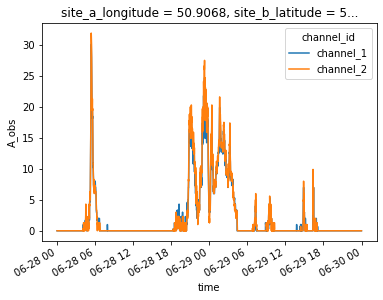

In [256]:
cml['A_obs'] = (cml.trsl - cml.baseline)
cml['A_obs'] = cml.A_obs.where(cml.A_obs >=0, 0)
cml.A_obs.plot.line(x='time');

In [257]:
# TODO: Allow to pass several channels and handle the required 1D array of frequencies
cml['waa'] = ('channel_id', 'time'), np.stack([
    pycml.processing.wet_antenna.waa_leijnse_2008_from_A_obs(
        A_obs=cml_ch.A_obs.values, 
        f_Hz=cml_ch.frequency.values*1e9, 
        L_km=cml_ch.length.values,
    ) for channel_name, cml_ch in cml.groupby('channel_id')
])

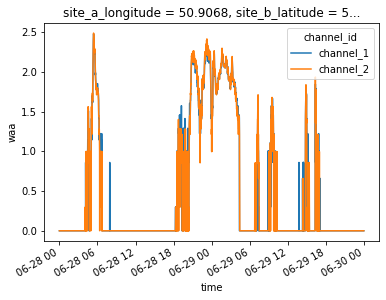

In [258]:
cml.waa.plot.line(x='time');

In [263]:
# Tried the WIP decorrator here as a function, but this does not work because 
# the function called insided would also need to be wrapped
waa_leijnse_2008_from_A_obs = xarray_loop_vars_over_dim(vars_to_loop=['A_obs', 'f_Hz'], loop_dim='channel_id')(
    pycml.processing.wet_antenna.waa_leijnse_2008_from_A_obs
)

waa_leijnse_2008_from_A_obs(
    A_obs=cml.A_obs.values, 
    f_Hz=cml.frequency.values*1e9, 
    L_km=cml.length.values,
)

ValueError: operands could not be broadcast together with shapes (100,) (2,) 

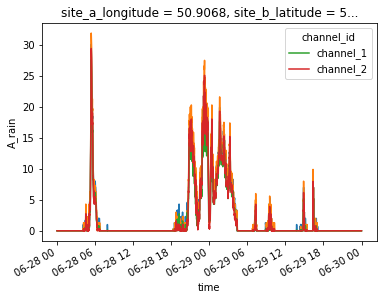

In [264]:
cml['A_rain'] = cml.A_obs - cml.waa
cml.A_obs.plot.line(x='time');
cml.A_rain.plot.line(x='time');

In [265]:
# TODO: Same as above, but also make units of L and f consistenst
cml['R'] = ('channel_id', 'time'), np.stack([
    pycml.processing.k_R_relation.calc_R_from_A(
        A=cml_ch.A_obs.values, 
        L=cml_ch.length.values,
        f_GHz=cml_ch.frequency.values,
    ) for channel_name, cml_ch in cml.groupby('channel_id')
])

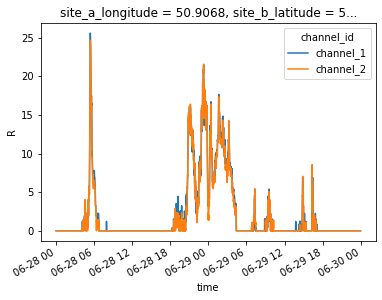

In [266]:
cml.R.plot.line(x='time');

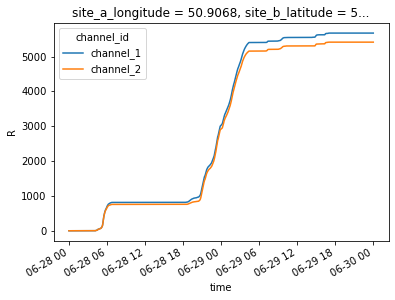

In [267]:
cml.R.cumsum(dim='time').plot.line(x='time');

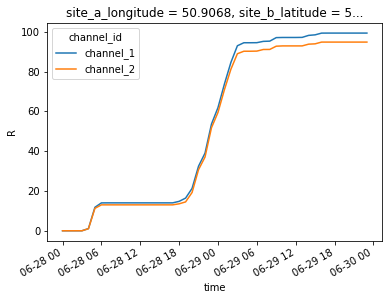

In [268]:
cml.R.resample(time='1h').mean().cumsum(dim='time').plot.line(x='time');

In [269]:
cml

<xarray.Dataset>
Dimensions:           (channel_id: 2, time: 2750)
Coordinates:
    site_a_longitude  float64 50.91
    site_b_latitude   float64 50.38
    cml_id            |S17 b'MY1394_2_MY2336_4'
    site_b_longitude  float64 50.38
    length            float64 13.48
    site_a_latitude   float64 50.26
    polarization      |S1 b'V'
  * time              (time) datetime64[ns] 2017-06-28T00:00:10.241754112 ... 2017-06-29T23:59:10.229434880
  * channel_id        (channel_id) object 'channel_1' 'channel_2'
    frequency         (channel_id) float64 18.2 19.2
Data variables:
    tsl               (channel_id, time) float64 14.0 14.0 14.0 ... 14.0 13.0
    rsl               (channel_id, time) float64 -47.0 -47.0 ... -47.0 -47.0
    trsl              (channel_id, time) float64 61.0 61.0 61.0 ... 61.0 60.0
    wet               (channel_id, time) bool False False False ... False False
    baseline          (channel_id, time) float64 61.0 61.0 61.0 ... 61.0 60.0
    A_obs             (channel_id, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    waa               (channel_id, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    A_rain            (channel_id, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    R                 (channel_id, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0